In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve,bicgstab
from scipy.interpolate import LinearNDInterpolator
import copy
import time
import pandas as pd
import solverFunctions as sf
import analysisFunctions as af
import os
import datetime
from tqdm import tqdm

i=0; dif=9.826e-05; res=2.035e-14; itt=440		


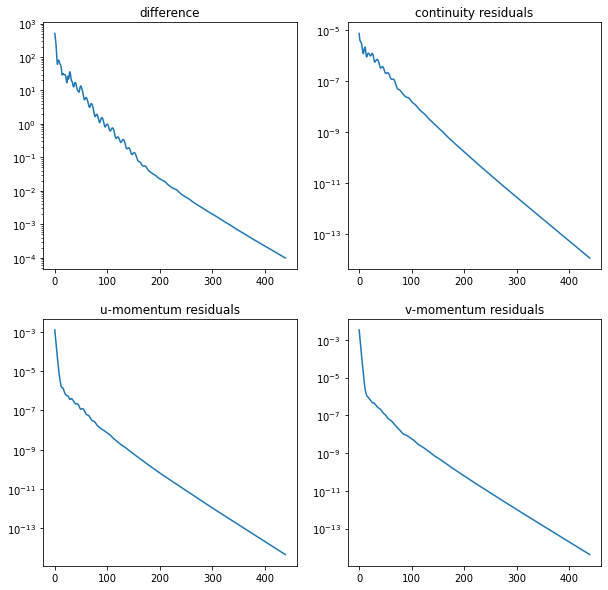

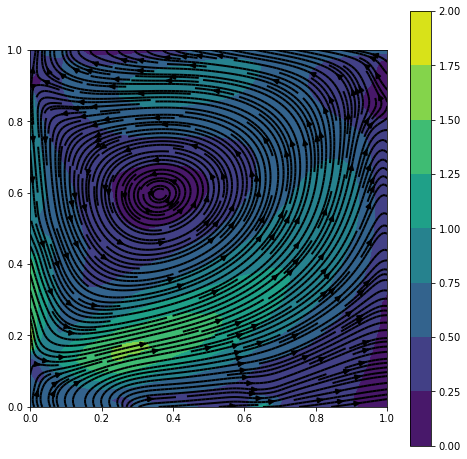

In [3]:
i=0
BCu_slice = BCu[i]
BCv_slice = BCv[i]
converged,u,v,p,prob,log = sf.SolveCFDfromBC(BCu_slice,BCv_slice,i,alpha_uv=0.15,alpha_p=0.05,order_grid=1,rho=1,mu=0.01,dt=np.inf,CDS=True,dif_tolerance=10**(-4))
af.PlotConvergence(log)
af.PlotFlow(u,v,prob)

In [3]:
files = os.listdir(r"DataDC/")
c_time = os.path.getmtime(r"DataDC/"+files[10])
dt_c = datetime.datetime.fromtimestamp(c_time)

In [14]:
u = np.zeros((3000,31,32))
v = np.zeros((3000,32,31))
p = np.zeros((3000,30,30))
indexes = []
index = 0
for i in range(4000):
    print('\r'+str(i),end="")
    try:
        u_slice = np.load(r"DataDC\Raw\dc_u_30_1_5_"+str(i)+".npy")
        u[index,:,:] = u_slice
        v_slice = np.load(r"DataDC\Raw\dc_v_30_1_5_"+str(i)+".npy")
        v[index,:,:] = v_slice
        p_slice = np.load(r"DataDC\Raw\dc_p_30_1_5_"+str(i)+".npy")
        p[index,:,:] = p_slice
        index+=1
        indexes.append(i)
    except:
        pass

u = u[:index,:,:]
v = v[:index,:,:]
p = p[:index,:,:]
print("\ndone")



3999
done


(3908, 31, 32)

In [2]:
BCu = np.zeros((1000,4,32))
BCv = np.zeros((1000,4,32))
indexes = []
index = 0
for i in range(2000):
    print('\r'+str(i),end="")
    try:
        BCu_slice = np.load(r"DataDC\Raw\dc_BCu_30_1_5_"+str(i)+".npy")
        BCu[index,:,:] = BCu_slice
        BCv_slice = np.load(r"DataDC\Raw\dc_BCv_30_1_5_"+str(i)+".npy")
        BCv[index,:,:] = BCv_slice
        index+=1
        indexes.append[i]
    except:
        pass

BCu = BCu[:index,:,:]
BCv = BCv[:index,:,:]
print("\ndone")


1999
done


dif=0.01371; res=1.359e-11; itt=2000		===>done


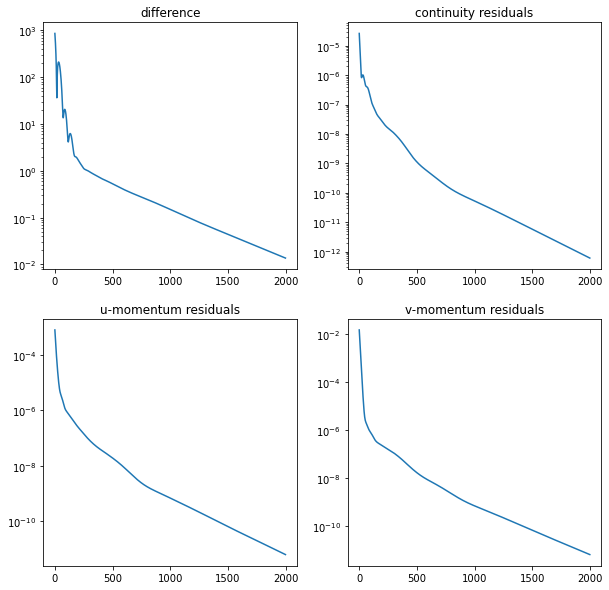

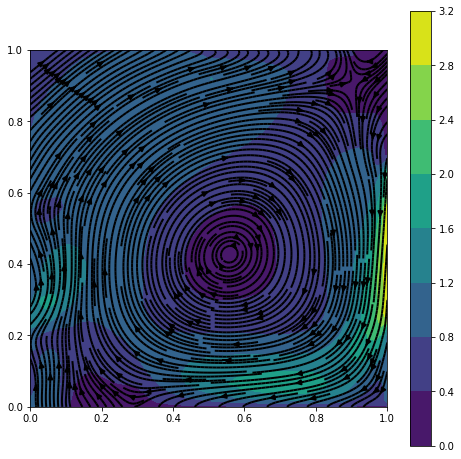

In [5]:
n = 30
rho = 1
mu = 0.01
nx = ny = n
dt = 0.1
alpha_uv = 0.05
alpha_p = 0.02
CDS = True
order = 1

i = 0
BCu_slice = BCu[i]
BCv_slice = BCv[i]

x = sf.get1Dgrid(n+1,order)
y = x
prob = sf.CFDproblem(x,y, 1, 0.01, BCu_slice, BCv_slice,dt,alpha_uv,alpha_p,CDS)
u,v,p,log = sf.SolveProblem(prob,showProgress=True)
af.PlotConvergence(log)
af.PlotFlow(u,v,prob)

In [19]:
u_old = np.load(r"DataDC/datasetDC_u_30_1_5.npy")
v_old = np.load(r"DataDC/datasetDC_v_30_1_5.npy")
p_old = np.load(r"DataDC/datasetDC_p_30_1_5.npy")

u = np.concatenate([u_old,u],axis=0)
v = np.concatenate([v_old,v],axis=0)
p = np.concatenate([p_old,p],axis=0)

np.save(r"DataDC/datasetDC_u_30_1_5.npy",u)
np.save(r"DataDC/datasetDC_v_30_1_5.npy",v)
np.save(r"DataDC/datasetDC_p_30_1_5.npy",p)

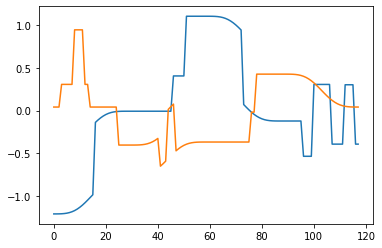

In [7]:
def BoundaryLine(BCu,BCv):
    u = np.concatenate([BCu[0,1:-2],BCu[3,1:-1],BCu[2,1:-2][::-1],BCu[1,1:-1][::-1]])
    v = np.concatenate([BCv[0,1:-1],BCv[3,1:-2],BCv[2,1:-1][::-1],BCv[1,1:-2][::-1]])
    return u,v

u,v = BoundaryLine(BCu[1],BCv[1])
plt.plot(u)
plt.plot(v)

100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


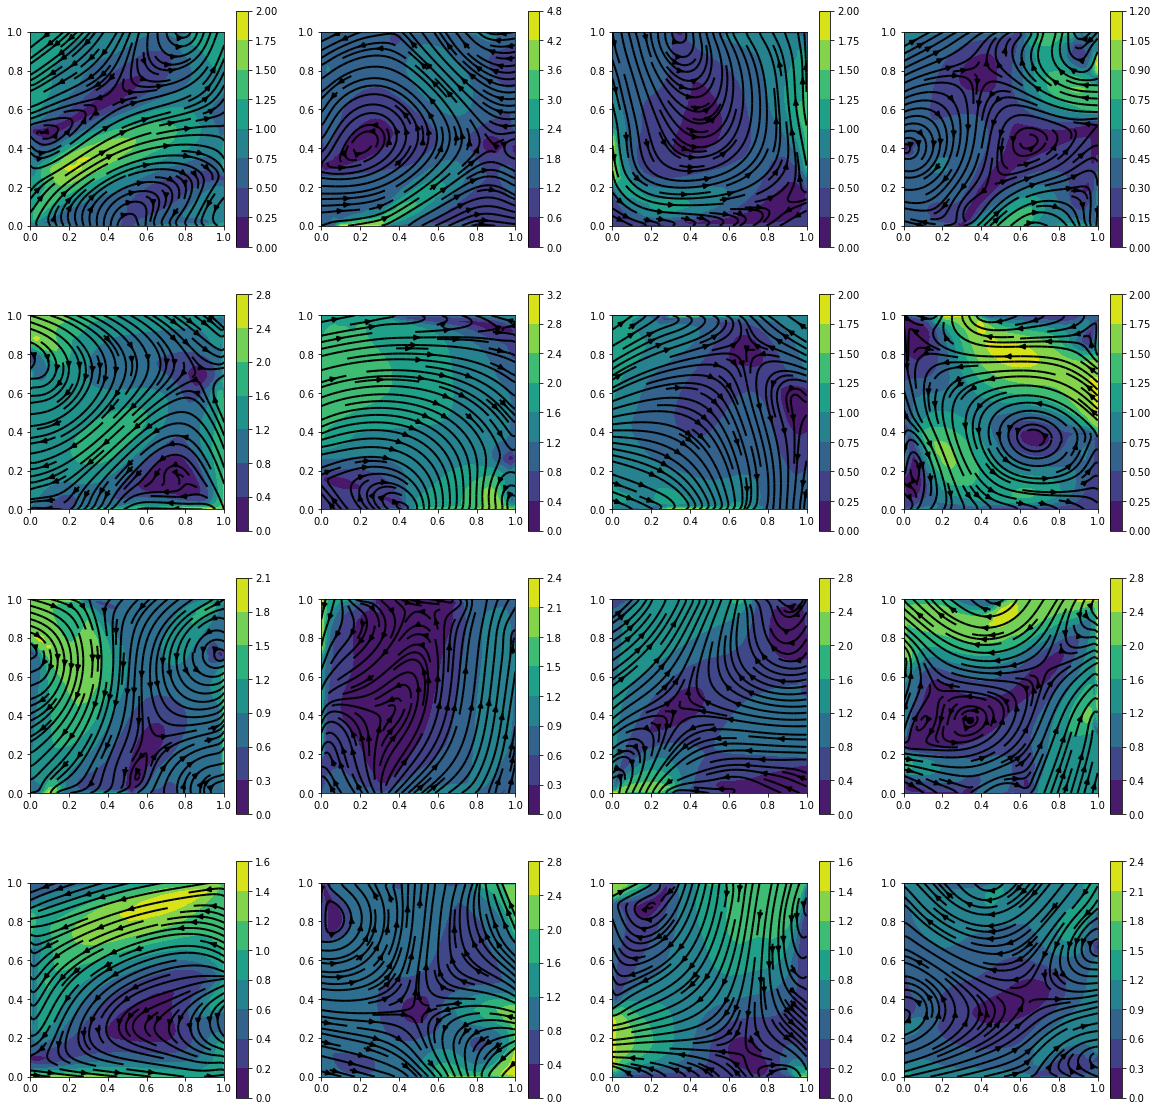

In [31]:
def SubplotFlow(a,b,u,v,prob):
    n = min(a*b,u.shape[0])
    plt.figure(figsize=(20,20))
    for i in tqdm(range(n)):
        X_n,Y_n = np.meshgrid(prob.xc_u,prob.yc_v)
        u_n = (u[i,:,:-1]+u[i,:,1:])/2
        v_n = (v[i,:-1,:]+v[i,1:,:])/2
        u_n = np.transpose(u_n)
        v_n = np.transpose(v_n)
        X,Y = np.meshgrid(np.linspace(0,1,u_n.shape[0]*2),np.linspace(0,1,u_n.shape[1]*2))
        points_n = np.concatenate([X_n.reshape(X_n.size,1),Y_n.reshape(Y_n.size,1)],axis=1)
        values_n = np.concatenate([u_n.reshape(u_n.size,1),v_n.reshape(v_n.size,1)],axis=1)
        interp = LinearNDInterpolator(points_n, values_n)
        values_i = interp(X,Y)
        u_c = values_i[:,:,0]
        v_c = values_i[:,:,1]
        ax = plt.subplot(a,b,i+1)
        ax.set_ylim([0,1])
        ax.set_xlim([0,1])
        c = ax.contourf(X,Y,np.sqrt(u_c**2+v_c**2))
        plt.colorbar(c)
        ax.streamplot(X,Y,u_c,v_c,color="k",linewidth=2,density=1)
        plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

prob = sf.GetProblem(30,1)
SubplotFlow(4,4,u[:],v[:],prob)